In [2]:
import numpy as np 
import pandas as pd
import Bio
from Bio.pairwise2 import format_alignment
import copy

import sys 
sys.path.append('../code_general_Finkelsteinlab/')

import Process_SeqLibrary_Finkelsteinlab as preprocess

import plotting_Finkelsteinlab as pltData

%matplotlib inline 
import matplotlib.pylab as plt 

In [3]:
import Prepare_data as Pre
path = '../Data_ABA_Finkelsteinlab/' 
filename= 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-2.csv'
xdata,ydata,yerr=Pre.Prepare_Cdata(path,filename)


In [4]:
upper_bnd =  [10.0] + [10.0]*40 +  [3.0] *2
lower_bnd = [0.0] + [-10.0]*40 + [-7.0] *2
initial_guess =  [5.0] + [0.0]*40 + [0.0] *2

In [5]:
import Chisq_Finkelstein as Chi
import SimulatedAnnealing_Finkelstein_parallel as SA
import sys
sys.path.append('../code_ABA_Finkelsteinlab/')
import Calculate_ABA_Finkelsteinlab as ABA

import functools

In [1]:
parameters =  np.array([5.0] + [1.0]*40 + [0.5] *2)
concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) # in nanoMolair
reference=1 # in nanomolair
#ontarget_ABA=ABA.calc_ABA(parameters,concentrations,reference, mismatch_positions=[],model_id = 'general_energies', guide_length = 20, T=10*60)
#mABA=ABA.calc_delta_ABA(parameters,concentrations,reference, xdata[0],ontarget_ABA,model_id = 'general_energies', guide_length = 20, T=10*60)

chi,mABA=Chi.calc_Chi_square(parameters,xdata[0:10],ydata[0:10],yerr[0:10],concentrations,
                             reference,guide_length=20,model_id='general_energies')
print(chi)
# plot to see the fit
import matplotlib.pylab as plt
plt.plot(range(10),mABA)
for i in range(10):
    m=np.ones(len(ydata[i]))*i
    plt.scatter(m,ydata[i])
#KineticModel(parameters,xdata[0],ydata[0],yerr[0])
print(mABA)
new_ydata=mABA

# IT DOES RUN, SO THE CHI SQUARE FUNCTION WORKS, THE REASON WHY IT IS SUCH A POOR FIT,
# IS THAT I JUST TOOK SOME INITIAL PARAMETERS

# Om het te laten werken, remove the # in the functie in python file!

NameError: name 'np' is not defined

In [6]:
gRNA_length = 20
model_ID = 'general_energies'
parameters =  np.array([5.0] + [1.0]*40 + [0.5] *2)
concentrations = np.array([0, 0.1, 0.3, 1, 3, 10, 30, 100, 300]) # in nanoMolair
reference=1 # in nanomolair

KineticModel = functools.partial(Chi.calc_Chi_square,model_id=model_ID, guide_length=20,
                                 concentrations=concentrations,reference=reference)
chi,mABA=KineticModel(parameters,xdata[0:10],ydata[0:10],yerr[0:10])
print(chi)

../code_ABA_Finkelsteinlab\Calculate_ABA_Finkelsteinlab.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return (1.0+Kd/C)**(-1)


TypeError: 'numpy.float64' object is not iterable

0.0


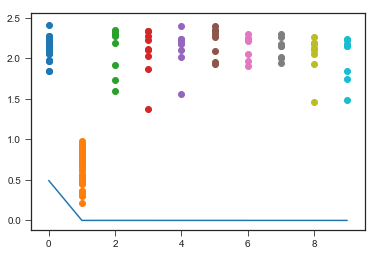

In [9]:
new_ydata=mABA
chi,mABA=Chi.calc_Chi_square(parameters,xdata[0:10],new_ydata,yerr[0:10],concentrations,
                             reference,guide_length=20,model_id='general_energies')
print(chi)
# plot to see the fit
import matplotlib.pylab as plt
plt.plot(range(10),mABA)
for i in range(10):
    m=np.ones(len(ydata[i]))*i
    plt.scatter(m,ydata[i])

In [ ]:
# to try without the working function from berouz
df=pd.DataFrame()
df['MMpos']=['1|6','1|6','7|2','8|3','19|1','15,8']
df['ABA']=[6,4,9,3,8,2]
df['Uncertainty']=[0.1,0.03,0.3,0.2,0.68,0.9]
Grouped = df.groupby('MMpos').agg(lambda x: list(x))
Grouped.reset_index(inplace=True)
Grouped


In [ ]:
s='7|22'
s.split('|')
mm = np.array(s.split('|')).astype(int)
mm

In [ ]:
MMpos=Grouped['MMpos'].tolist()
ABA=Grouped['ABA'].tolist()
Uncertainty=Grouped['Uncertainty'].tolist()

#df['df.apply('functionname',axis=1)

In [ ]:
Path = '../Data_ABA_Finkelsteinlab/cas9-target-e-replicate-1-delta-abas.txt'
data = pd.read_table(Path,comment='#')
#data

In [ ]:
Cas='Cas9'
on_target = 'TTTAGACGCATAAAGATGAGACGCTGG'
seq_colname = 'Sequence'
output_colnames = ['Delta ABA (kBT)', 'Uncertainty']
out_file_name = 'Cas9_target_e.csv'
out_path = '../Data_ABA_Finkelsteinlab/cas9-target-e-replicate-1-delta-abas.txt'

new_data = preprocess.process_Finkelstein_Library(data, on_target, seq_colname, output_colnames, Cas, 
                                                  Canonical_PAM = True, Mut_type = ['OT','r'], Mut_min = 0, Mut_max = 20,
                                                  out_file_name = out_file_name, out_path = out_path, nofilter = False,
                                                  save_data = True)


In [ ]:
fit_result_file= 'fit_results.txt'
monitor_file = 'monitor.txt'
init_monitor_file='init_monitor.txt'

gRNA_length = 20
model_ID = 'general_energies'
parameters =  np.array([5.0] + [1.0]*40 + [0.5] *2)
concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) # in nanoMolair
reference=1 # in nanomolair

KineticModel = functools.partial(Chi.calc_Chi_square,model_id=model_ID, guide_length=20,
                                 concentrations=concentrations,reference=reference)

fit_result = SA.sim_anneal_fit(xdata=xdata[0],
                                ydata=ydata[0],
                                yerr = yerr[0],
                                Xstart= np.array(initial_guess),
                                lwrbnd= np.array(lower_bnd),
                                upbnd= np.array(upper_bnd),
                                model='I_am_using_multi_processing_in_stead',
                                objective_function=KineticModel,
                                on_target_function=ABA.calc_ABA,
                                Tstart=100.,             # infered from run on my computer/other runs on cluster
                                use_relative_steps=False,
                                delta=1.0,
                                tol=1E-5,
                                Tfinal=50,
                                adjust_factor=1.1,
                                cooling_rate=0.5,
                                N_int=10,
                                AR_low=0,
                                AR_high=100,
                                use_multiprocessing=True,
                                nprocs=1,
                                output_file_results = fit_result_file,
                                output_file_monitor = monitor_file,
                                output_file_init_monitor=init_monitor_file
                              )

In [ ]:
def f(a,b):
    return a+b
import functools
g=functools.partial(f,b=5)
print(f(1,5))
print(g(1))